In [2]:
%load_ext autoreload
%autoreload 2

Import code

In [3]:
import sys
sys.path.append("./code")
import analysis_functions
import make_droso_figures
from process_loops import *
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def row2tuple(row):
    chrom, s, e = row
    return (chrom, int(s), int(e))

def remove_chr(bedtool):
    new = []
    for i in bedtool:
        i = list(i)

        i[0]=i[0][3:]
        new.append(tuple(i))
    return pbt.BedTool(new)

def make_index(df):
    index = []
    for _, i in df.iterrows():
        index.append('_'.join(i.astype(str)[:6]))
    return index
    
clust2index = {
    '233,213,86' : 2,
    '0,209,152' : 3,   
    '233,86,107' : 1,
    '86,180,233' : 0,
}

In [4]:
gpath = './dm6/nochr.sizes'
arr = np.asarray

Functions for making downstream dataframes

In [5]:
def make_loop_df():
    loops = pbt.BedTool('./loop_calling/final_loops/full_loops.loops')
    loop_df = loops.to_dataframe()
    
    cluster1 = []
    cluster2 = []
    indexes = []
    for _, i in loop_df.iterrows():
        indexes.append('_'.join(i.astype(str)))
        i = i.values
        anc1, anc2 = (i[0], i[1], i[2]), (i[3], i[4], i[5])
        anc1, anc2 = make_int(anc1), make_int(anc2)
        cluster1.append(anchor2cluster.get(anc1, "NAB"))
        cluster2.append(anchor2cluster.get(anc2, "NAB"))
    loop_df['cluster1'] = cluster1
    loop_df['cluster2'] = cluster2
    loop_df['color1'] = [str(cluster_to_rgb.get(x, "255,255,255")) for x in loop_df['cluster1']]
    loop_df['color2'] = [str(cluster_to_rgb.get(x, "255,255,255")) for x in loop_df['cluster2']]
    loop_df.index = indexes
    return loop_df

In [6]:
def make_loop_to_rgb():
    loop_to_rgb = {}
    for i, row in loop_df.iterrows():
        b1, b2 = '_'.join(row[:3].apply(lambda x: str(x))), '_'.join(row[3:6].apply(lambda x: str(x)))
        c1, c2 = row.cluster1, row.cluster2
        if c1 == 'NAB':
            c1 = '4'
        if c2 == 'NAB':
            c2 = '4'
        loop_to_rgb[f'{b1}_{b2}'] = [c1, c2]
    return loop_to_rgb

In [7]:
rgb_to_cluster = {
    '86,180,233' : 0,
    '233,86,107' : 1,
    '233,213,86' : 2,
    '0,209,152' : 3,
}
cluster_to_rgb = dict(zip(rgb_to_cluster.values(), rgb_to_cluster.keys()))

In [18]:
!mkdir -p loop_calling/final_loops/differential/merged/processed_deseq

Load differential loops from DESeq2

In [17]:
import glob
dfdict = {}
for file in glob.glob('./loop_DESEQ2/DESEQ2//output/*.csv'):
    subfile = file.split("loose_")[1].split(".csv")[0]
    cond1, cond2 = subfile.split("_vs_")

    processed_df = process_deseq_output(file)
    processed_df.index = make_index(processed_df)
    dfdict[f'{cond1}_vs_{cond2}'] = processed_df

In [11]:
pref = 'loop_and_boundary_output/'
anchor_df = pd.read_csv(pref + 'unmerged_merged_loop_anchor_to_cluster.tsv', sep='\t',)

anchor2cluster = {}
for i, row in anchor_df.iterrows():
    anchor = (row['chrom'], row['start'], row['end'])
    cluster = row.cluster
    anchor2cluster[anchor] = cluster

In [12]:
loop_df = make_loop_df()

In [13]:
loop_to_rgb = make_loop_to_rgb()

### Fraction of loops up vs. down

In [14]:
from copy import deepcopy
def add_chr_to_loop(l):
    loop = deepcopy(list(l))
    if 'chr' not in loop[0]:
        loop[0] = 'chr' + loop[0]
    if 'chr' not in loop[3]:
        loop[3] = 'chr' + loop[3]
    return loop

def make_df_from_dict(dic, **kwargs):
    df = pd.DataFrame()
    values = []
    labels = []
    for key in dic:
        values = values + dic[key]
        labels = labels + [key]*len(dic[key])
    df['values']=values
    df['labels']=labels
    return df

In [21]:
loop_df_with_lfc_dict = {}
for cond in ['nc14_vs_nc1.8', 'nc14_vs_s10.12', 
             'nc14.FED_vs_nc12.mitotic.FED', 'nc14.FED.rerun_vs_nc12.mitotic.FED.rerun',
            'nc14.FED.rerun_vs_nc14']:
    deseq_dict = dfdict[cond]
    cond1, cond2 = cond.split("_vs_")
    loop_df_with_lfc_and_boundary_clusters = pd.concat([loop_df, deseq_dict], axis=1)

    loop_df_with_lfc_dict[cond] = loop_df_with_lfc_and_boundary_clusters

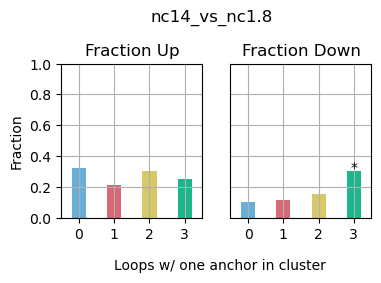

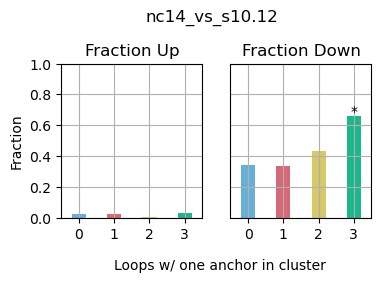

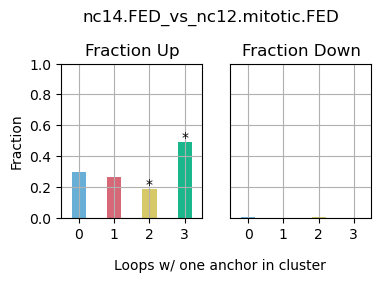

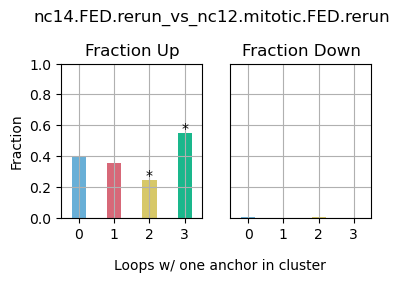

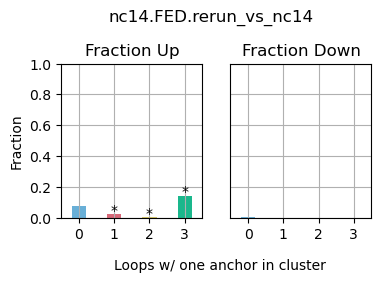

In [23]:
import seaborn as sns
from ast import literal_eval

for cond in loop_df_with_lfc_dict:
    tmp_loop_df = loop_df_with_lfc_dict[cond].copy()
    valdict_up = {}
    valdict_down = {}
    bad = ((tmp_loop_df['cluster1']=='NAB') | (tmp_loop_df['cluster2']=='NAB'))
    tmp_loop_df = tmp_loop_df[~bad]
    
    pvaldict_down = {}
    pvaldict_up = {}
    for u in ['0', '1', '2', '3']:
        indsoi1 = tmp_loop_df['cluster1'].astype(str) == u
        indsoi2 = tmp_loop_df['cluster2'].astype(str) == u
        indsoi = indsoi1 | indsoi2
        frac_down = np.nanmean((tmp_loop_df[indsoi]['l2fc'] < 0) & (tmp_loop_df[indsoi]['padj'] < .05))
        frac_up = np.nanmean((tmp_loop_df[indsoi]['l2fc'] > 0) & (tmp_loop_df[indsoi]['padj'] < .05))
        valdict_down[u] = [frac_down]
        valdict_up[u] = [frac_up]
        
        n_down = np.nansum((tmp_loop_df['l2fc'] < 0) & (tmp_loop_df['padj'] < .05))
        n_up = np.nansum((tmp_loop_df['l2fc'] > 0) & (tmp_loop_df['padj'] < .05))
        
        n_down_in_cluster = np.nansum((tmp_loop_df[indsoi]['l2fc'] < 0) & (tmp_loop_df[indsoi]['padj'] < .05))
        n_up_in_cluster = np.nansum((tmp_loop_df[indsoi]['l2fc'] > 0) & (tmp_loop_df[indsoi]['padj'] < .05))        
        
        n_in_cluster = np.nansum(indsoi)
        n_in_cluster = np.nansum(indsoi)
        n = len(tmp_loop_df)
        pval_down = scipy.stats.fisher_exact([[n_down_in_cluster, n_down], [n_in_cluster, n]])[1]
        pval_up = scipy.stats.fisher_exact([[n_up_in_cluster, n_up], [n_in_cluster, n]])[1]

        pvaldict_down[u] = [pval_down]
        pvaldict_up[u] = [pval_up]
        
    valdf_up = make_df_from_dict(valdict_up)
    valdf_down = make_df_from_dict(valdict_down)
    pvaldf_up = make_df_from_dict(pvaldict_up)
    pvaldf_down = make_df_from_dict(pvaldict_down)
    pvaldf_up['values'] = statsmodels.stats.multitest.fdrcorrection(pvaldf_up['values'])[1]
    pvaldf_down['values'] = statsmodels.stats.multitest.fdrcorrection(pvaldf_down['values'])[1]

    plotting_parameters_up = {
        'data':    valdf_up,
        'x':       'labels',
        'y':       'values',
        'palette' : [arr(literal_eval(x))/255 for x in list(cluster_to_rgb.values())],
        'width' : .4,
    }
    plotting_parameters_down = {
        'data':    valdf_down,
        'x':       'labels',
        'y':       'values',
        'palette' : [arr(literal_eval(x))/255 for x in list(cluster_to_rgb.values())],
        'width' : .4,
    }
    
    fig, axs = plt.subplots(1, 2, figsize=(4, 2), sharey=True)
    ax = axs[0]
    sns.barplot(ax=ax, **plotting_parameters_up)
    ax.set_title('Fraction Up')
    ax.set_xlabel("")
    ax.set_ylabel("Fraction")
    ax.set_ylim([0, .7])
    for c in range(4):
        pval = (pvaldf_up[pvaldf_up['labels']==str(c)]['values'] < .05)
        val = (valdf_up[valdf_up['labels']==str(c)])['values']
        if pval.any():
            ax.text(c, val, '*', ha='center')
    
    ax = axs[1]
    sns.barplot(ax=ax, **plotting_parameters_down)
    ax.set_title("Fraction Down")
    ax.set_xlabel("")
    ax.set_ylabel("")
#     ax.set_yticklabels([])
    ax.tick_params(left=False)
    ax.set_ylim([0, 1])
    for c in range(4):
        pval = (pvaldf_down[pvaldf_down['labels']==str(c)]['values'] < .05)
        val = (valdf_down[valdf_down['labels']==str(c)])['values']
        if pval.any():
            ax.text(c, val, '*', ha='center')
    
    for ax in axs:
        ax.grid()
    fig.suptitle(cond, y=1.15)
    ax.text(x=-.8, y=-.34, s="Loops w/ one anchor in cluster", ha='center')

### Supplementary Heatmap

Visualize O/E at all loops

In [33]:
def get_distances(df):
    ds = []
    for x in df.index:
        _ = x.split("_")
        ds.append(abs(int(_[1]) - int(_[4])))
    return ds

def convert_colors_into_rgb(index, idx=0):
    return [arr(literal_eval(x))/255 for x in index]

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import pybedtools as pbt

readcount_df = pd.read_csv('loop_and_boundary_output/looping_df.csv', index_col=0)

rowsoi = readcount_df['shifted']==0
colsoi = readcount_df.columns[readcount_df.columns.str.contains("oe")]
colsoi = colsoi[~colsoi.str.contains("shifted")]
oedf = readcount_df.loc[rowsoi, colsoi]

In [29]:
sig_cols = []
for condition in ['s10.12_vs_nc14', 'nc14_vs_nc1.8', 
                  'nc14.FED_vs_nc12.mitotic.FED', 'nc14.FED.rerun_vs_nc12.mitotic.FED.rerun']:
    subdf = readcount_df.loc[rowsoi]
    sig_col = (subdf[f'padj_{condition}'] < .05).astype(int)
    up = (subdf[f'log2FoldChange_{condition}'] > 0)
    down = (subdf[f'log2FoldChange_{condition}'] < 0)
    sig_col[down] *= -1
    sig_col.name = condition
    sig_cols.append(sig_col)

In [30]:
logoe_df = np.log2(oedf[(oedf==0).sum(axis=1) < 1]+.1)
logoe_df = np.log2(oedf+.1)

In [34]:
clustercol1 = convert_colors_into_rgb(loop_df.loc[logoe_df.index]['color1'])
clustercol2 = convert_colors_into_rgb(loop_df.loc[logoe_df.index]['color2'])

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


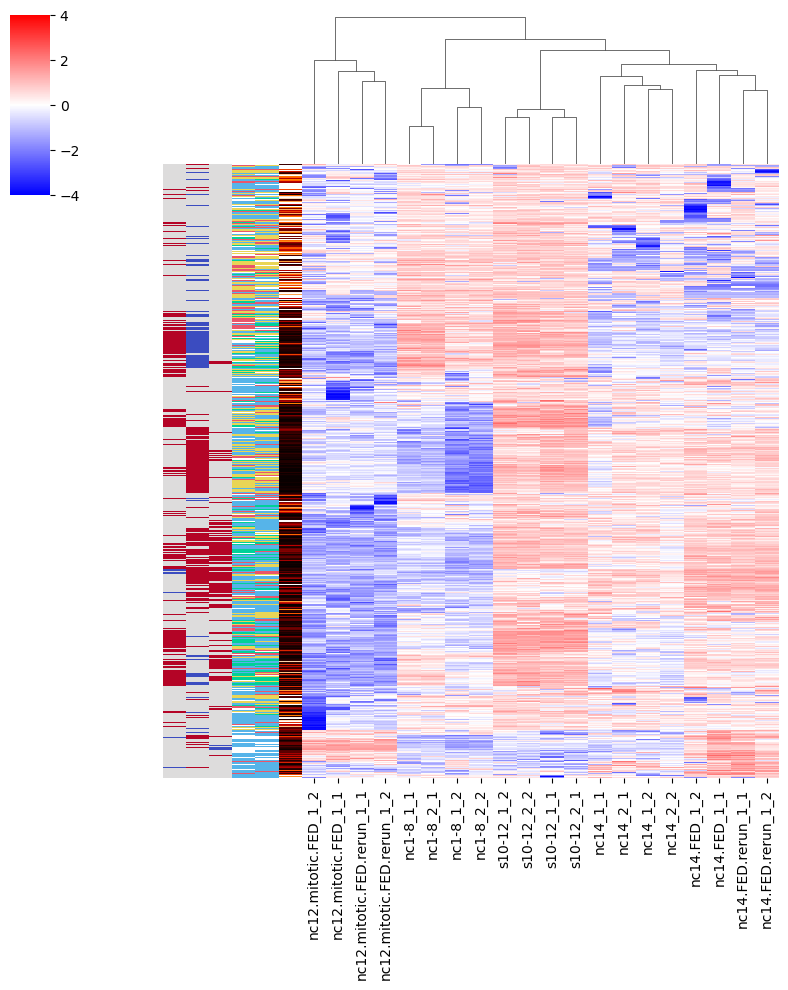

In [37]:

ds = get_distances(logoe_df)
ds = [sns.color_palette('gist_heat', as_cmap=True)(x/np.nanquantile(ds, .9)) for x in ds]
ds = pd.Series(ds, index = oedf.index)

color_df = [sig_col.apply(lambda x: sns.color_palette('coolwarm', as_cmap=True)((x+1)/2)) for sig_col in sig_cols]
logoe_df.columns = logoe_df.columns.str.replace('_oe', '')
g = sns.clustermap(logoe_df, cmap='bwr', row_colors=color_df[:3] + [clustercol1, clustercol2, ds], 
                 z_score=0, vmin = -4, vmax = 4, rasterized=True,
                   figsize=(8, 10), yticklabels=False, xticklabels=True,
                  )
g.ax_row_dendrogram.set_visible(False)
# g.figure.savefig('./plots/supplementary/loop_oe_heatmap_row_normalized.svg')

### O/E at NC14 plot

Visualize which loop clusters are enriched for contact

In [38]:
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'


from ast import literal_eval
loop_colors = []
clusters1 = []
clusters2 = []
for x in oedf.index:
    col1, col2 = loop_to_rgb.get(x, ['NAB', 'NAB'])

    clusters1.append(col1)
    clusters2.append(col2)

clusters1 = arr(clusters1).astype(int)
clusters2 = arr(clusters2).astype(int)

sort_clusters1 = clusters1.copy()
sort_clusters2 = clusters2.copy()

sort_clusters1[clusters1 < clusters2] = clusters1[clusters1 < clusters2]
sort_clusters1[clusters2 < clusters1] = clusters2[clusters2 < clusters1]
sort_clusters2[clusters1 < clusters2] = clusters2[clusters1 < clusters2]
sort_clusters2[clusters2 < clusters1] = clusters1[clusters2 < clusters1]


/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0 0 3.6498551915016436e-20
0 1 0.20232946062827317
0 2 0.9449383066452707
0 3 0.5862436942612403
1 1 0.6673004103036311
1 2 0.9939425440261181
1 3 0.7380988565222908
2 2 0.9999999999999984
2 3 0.9999879804503918
3 3 0.00264596816179138


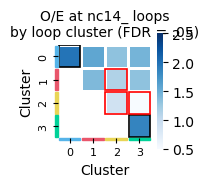

In [39]:
from matplotlib import patches
for stage in ['nc14_', 'nc1-8', 's10-']:
    stage_oe = oedf[oedf.columns[oedf.columns.str.contains(stage)]]/9
    stage_oe = stage_oe.mean(axis=1)
    bop = pd.DataFrame(np.log2(stage_oe))
    bop['cluster1'] = (sort_clusters1)
    bop['cluster2'] = (sort_clusters2)

    bop = bop[bop['cluster2'] != 4]
    bop = bop[bop[0] != -np.inf]

    a = bop.groupby(["cluster1", 'cluster2']).mean().unstack()
    a = a.unstack().unstack().loc[0].T
    fig, ax = plt.subplots(figsize=(1.5, 1.5))
    sns.heatmap(a, cmap='Blues', ax=ax, linewidth=2, square=True, 
                vmax=2.5, vmin=.5
               )

    pvals = []
    keys = []
    for u1 in np.unique(bop['cluster1']):
        for u2 in np.unique(bop['cluster2']):
            if u1 > u2:
                continue
            indsoi = (bop['cluster1'] == u1) & (bop['cluster2'] == u2)
            pval = scipy.stats.ttest_ind(bop[indsoi][0], bop[~indsoi][0], alternative='greater')[1]
            keys.append([u2, u1])
            pvals.append(pval)
            print(u1, u2, pval)

    pvals = statsmodels.stats.multitest.fdrcorrection(pvals)[1]

    for c, k in enumerate(keys):
        key1, key2 = map(int, k)

        dx = 1-.03*2-.005
        dy = dx-.01
        if pvals[c] < .05:
            patch = patches.Rectangle((key1+.03, key2+.03), dy, dx,
                                      color='black', clip_on=True, linewidth=1.2,
                                      fill=False, zorder=1)
            ax.add_patch(patch)        

    pvals = []
    keys = []
    for u1 in np.unique(bop['cluster1']):
        for u2 in np.unique(bop['cluster2']):
            if u1 > u2:
                continue
            indsoi = (bop['cluster1'] == u1) & (bop['cluster2'] == u2)
            pval = scipy.stats.ttest_ind(bop[indsoi][0], bop[~indsoi][0], alternative='less')[1]
            keys.append([u2, u1])
            pvals.append(pval)
    pvals = statsmodels.stats.multitest.fdrcorrection(pvals)[1]

    for c, k in enumerate(keys):
        key1, key2 = map(int, k)

        dx = 1-.03*2-.005
        dy = dx-.01
        if pvals[c] < .1:
            patch = patches.Rectangle((key1+.03, key2+.03), dy, dx,
                                      color='red', clip_on=True, linewidth=1.2,
                                      fill=False, zorder=1)
            ax.add_patch(patch)                                

    for c in range(4):
        dx = .92
        dy = .1
        patch = patches.Rectangle((c+.04, 4), dx, dy,
                                  color=arr(literal_eval(cluster_to_rgb[c]))/255, clip_on=False, 
                                  fill=True, zorder=1)
        ax.add_patch(patch)      

        patch = patches.Rectangle((-.12, c+.04), dy, dx,
                                  color=arr(literal_eval(cluster_to_rgb[c]))/255, clip_on=False, 
                                  fill=True, zorder=1)
        ax.add_patch(patch)                                

    ax.set_title(f"O/E at {stage} loops\nby loop cluster (FDR = .05)", fontsize=10)
    ax.set_xlabel("Cluster", fontsize=10); 
    ax.set_ylabel("Cluster", fontsize=10);
    fig.savefig(f"./plots/supplementary/oe_by_loop_cluster_at_{stage}.svg")
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
    break

### Neighboring boundaries plot

Visualize which anchor clusters are enriched for being adjacent in the genome

In [40]:
clust2index = {
    '233,213,86' : 2,
    '0,209,152' : 3,   
    '233,86,107' : 1,
    '86,180,233' : 0,
}

In [26]:
pref = 'loop_and_boundary_output/browser_tracks/'
boundary_dict = {
    'nc14' : pbt.BedTool(pref + 'nc14_1_1+1_2+2_1+2_2.boundaries_and_both_with_cluster_colors.scores=plain.bed'),
    'nc1-8' : pbt.BedTool(pref + 'nc1-8_1_1+1_2+2_1+2_2.boundaries_and_both_with_cluster_colors.scores=plain.bed'),
    's10' : pbt.BedTool(pref + 's10-12_1_1+1_2+2_1+2_2.boundaries_and_both_with_cluster_colors.scores=plain.bed'),
    'nc14_FED' : pbt.BedTool(pref + 'nc14_FED_all_1_1+1_2.boundaries_and_both_with_cluster_colors.scores=plain.bed'),
    'nc12_mitotic_FED' : pbt.BedTool(pref + 'nc12_mitotic_FED_all_1_1+1_2.boundaries_and_both_with_cluster_colors.scores=plain.bed'),
}


In [44]:
boundary_counts = boundary_dict['nc14'].to_dataframe().iloc[:, -1].value_counts()
boundary_fracs = boundary_counts/boundary_counts.sum()

analytical_trans_probabilities = np.zeros((4, 4))

for c in range(4):
    for c2 in range(4):
        i1 = clust2index[boundary_fracs.index[c]]
        i2 = clust2index[boundary_fracs.index[c2]]
        analytical_trans_probabilities[i1, i2] = boundary_fracs[c]*boundary_fracs[c2]

In [45]:
trans_probabilities = np.zeros((4, 4))
random_trans_probabilities = np.zeros((4, 4))
boundaries = list(boundary_dict['nc14'].sort())
for c, i in enumerate(boundaries):
    if c == 0:
        continue
    else:
        pastbound = boundaries[c-1]
        currbound = boundaries[c]
        chrom1 = pastbound[0]
        chrom2 = currbound[0]
        if chrom1 != chrom2:
            continue
        else:
            pastclust = pastbound[-1]
            currclust = currbound[-1]
            pastind = clust2index[pastclust]
            currind = clust2index[currclust]
            trans_probabilities[pastind, currind] += 1
            trans_probabilities[currind, pastind] += 1
            
            randnum1 = np.random.randint(len(boundaries))
            randnum2 = np.random.randint(len(boundaries))
            randind1 = clust2index[boundaries[randnum1][-1]]
            randind2 = clust2index[boundaries[randnum2][-1]]
            random_trans_probabilities[randind1, randind2] += 1
            random_trans_probabilities[randind2, randind1] += 1
            
trans_probabilities /= trans_probabilities.sum()
# random_trans_probabilities /= random_trans_probabilities.sum()

In [46]:
n_each_cluster = trans_probabilities.sum(axis=0)

[Text(0, 0.5, '0'), Text(0, 1.5, '1'), Text(0, 2.5, '2'), Text(0, 3.5, '3')]

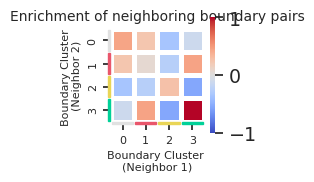

In [47]:

import seaborn as sns
import matplotlib.patches as patches
arr = np.asarray
from ast import literal_eval
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

cluster_to_rgb = {0: '225,225,225',
 1: '233,86,107',
 2: '233,213,86',
 3: '0,209,152',
 'NAB': '255,255,255'}

sns.set(font_scale=1.25)
sns.set_style('ticks')
fig, ax = plt.subplots(1, figsize=(1.5, 1.5))
sns.heatmap(np.log2(trans_probabilities/analytical_trans_probabilities), ax=ax, 
            cmap='coolwarm', vmin=-1, vmax=1, linewidth=2.5, square=True)
ax.set_title("Enrichment of neighboring boundary pairs", fontsize=10)
ax.set_xlabel("Boundary Cluster \n(Neighbor 1)", fontsize=8)
ax.set_ylabel("Boundary Cluster \n(Neighbor 2)", fontsize=8)

for c in range(4):
    dx = .92
    dy = .1
    patch = patches.Rectangle((c+.04, 4), dx, dy,
                              color=arr(literal_eval(cluster_to_rgb[c]))/255, clip_on=False, 
                              fill=True, zorder=1)
    ax.add_patch(patch)      

    patch = patches.Rectangle((-.12, c+.04), dy, dx,
                              color=arr(literal_eval(cluster_to_rgb[c]))/255, clip_on=False, 
                              fill=True, zorder=1)
    ax.add_patch(patch)    
ax.set_xticks([.5, 1.5, 2.5, 3.5])
ax.set_xticklabels(ax.get_yticklabels(), fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
# fig.savefig('./plots/supplementary/neighboring_boundary_pairs.svg', bbox_inches='tight')

### Pileup

Pileup loops

In [342]:
import cooler
import pandas as pd

res=800

cool_nc18 = cooler.Cooler(f'./cools/nc1-8_1_1+1_2+2_1+2_2.base_resolution=100.mcool::/resolutions/{res}')
cool_nc14 = cooler.Cooler(f'./cools/nc14_1_1+1_2+2_1+2_2.base_resolution=100.mcool::/resolutions/{res}')
cool_s10 = cooler.Cooler(f'./cools/s10-12_1_1+1_2+2_1+2_2.base_resolution=100.mcool::/resolutions/{res}')

chromlist = [x for x in cool_nc14.chromsizes.index  if x!='M']
chromo_keys_no_chr = list(['2L', '2R', '3L', '3R', '4', 'X', 'Y'])

cool_dict = {
    'nc18' : cool_nc18,
    'nc14' : cool_nc14,
    's10' : cool_s10,
}

nc14_expected = pd.read_csv(f'./cools/expected/expected_nc14_1_1+1_2+2_1+2_2.base_resolution=100.mcool_800.tsv', sep='\t')
nc14_expected['region'] = nc14_expected['region'].apply(lambda x: str(x))

nc18_expected = pd.read_csv(f'./cools/expected/expected_nc1-8_1_1+1_2+2_1+2_2.base_resolution=100.mcool_800.tsv', sep='\t')
nc18_expected['region'] = nc18_expected['region'].apply(lambda x: str(x))

s10_expected = pd.read_csv(f'./cools/expected/expected_s10-12_1_1+1_2+2_1+2_2.base_resolution=100.mcool_800.tsv', sep='\t')
s10_expected['region'] = nc18_expected['region'].apply(lambda x: str(x))

expected_dict = {
    'nc18' : nc18_expected,
    'nc14' : nc14_expected,
    's10' : s10_expected,    
}

In [345]:
from make_droso_figures import *

loopset = set()
for i in loops:
    loopset.add(i)
full_loop_apa = apa_noroll(list(loopset), cool_dict, expected_dict, wsz=20, skip_small=False)

3


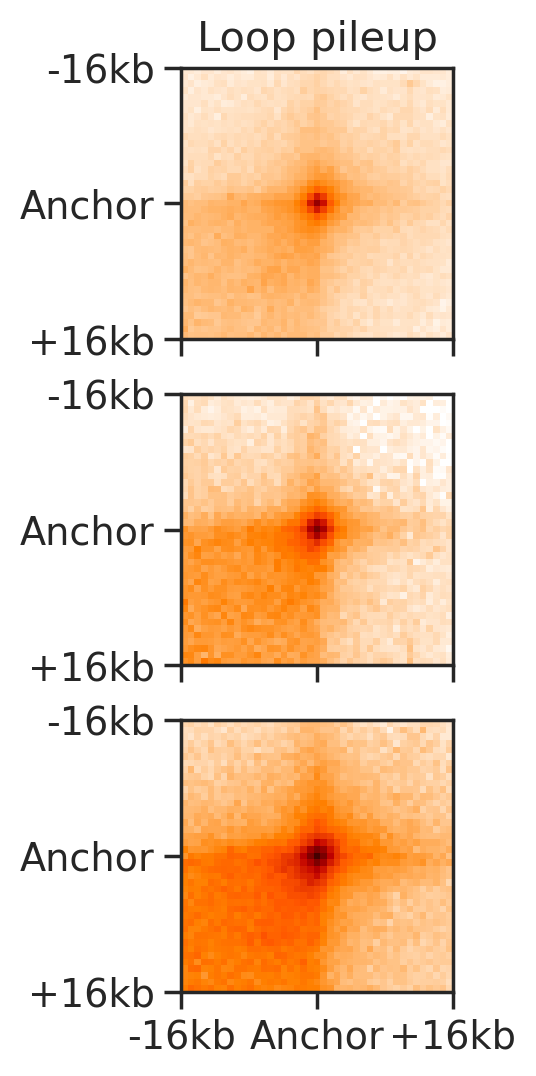

In [427]:
fig, axs = plt.subplots(3, 1, figsize=(4*.5, 12*.5, ), dpi = 200)
for c, apa_key in enumerate(full_loop_apa[0]):
    num = full_loop_apa[0][apa_key]
    den = full_loop_apa[1][apa_key]
    m = np.log2(np.nanmean(num / den, axis=0))

    axs[c].matshow(m, cmap='gist_heat_r', extent = [-20*800/1e3, 20*800/1e3, 
                                                    20*800/1e3, -20*800/1e3],
                  vmin = .1, vmax=4)
    axs[c].set_yticks([-16, 0, 16])
    axs[c].set_xticks([-16, 0, 16])
    axs[c].set_yticklabels([f'-16kb', 'Anchor', '+16kb'])
    axs[c].set_xticks([-16, 0, 16])

    axs[c].set_xticklabels([f'-16kb', 'Anchor', '+16kb'])
    if c < 2:
        axs[c].set_xticklabels([])
        axs[c].tick_params(bottom=True, labelbottom=True,  top=False, labeltop=False)        
    axs[c].tick_params(bottom=True, labelbottom=True,  top=False, labeltop=False)
axs[0].set_title("Loop pileup")

plt.subplots_adjust(hspace=.2)